In [69]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

In [19]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(device)

mps


In [71]:
def fig_ax(nrows=1, figsize=(15, 3)):
    return plt.subplots(nrows=nrows, figsize=(figsize[0], figsize[1] * nrows))

In [5]:
data = pd.read_csv('X_train.csv')
data.set_index("Horodate", inplace=True)
data.drop(columns=["holed_192"], inplace=True)

In [6]:
data_train = pd.read_csv('y_train.csv')
data_train.set_index("Horodate", inplace=True)
data_train.dropna(axis=1, inplace=True)
data_train.isnull().sum().max()

np.int64(0)

In [46]:
feature_TS_train = [col for col in data.columns if 'holed' not in col]
holed_T_train  = [col for col in data.columns if 'holed' in col]

TS_complete = data.loc[:,feature_TS_train].copy()
TS_missing = data.loc[:,holed_T_train].copy()

In [47]:
TS_complete

,5423908671,2568793410,8310762594,6235194807,423895617,193845276,216589743,218753964,1794650328,9253476180,...,2187645930,6502938147,9185760234,4972518063,9638012547,294387516,271684359,2967158034,1973824650,9625401873
Horodate,,,,,,,,,,,,,,,,,,,,,
2023-01-09 00:00:00,352.0,0.0,371.0,110.0,724.0,102.0,256.0,7.0,105.0,44.0,...,308.0,245.0,185.0,95.0,210.0,90.0,66.0,265.0,28.0,1058.0
2023-01-09 00:30:00,405.0,0.0,363.0,108.0,478.0,147.0,281.0,8.0,134.0,36.0,...,1097.0,235.0,188.0,81.0,143.0,74.0,73.0,195.0,30.0,1298.0
2023-01-09 01:00:00,599.0,0.0,352.0,93.0,832.0,155.0,295.0,5.0,96.0,22.0,...,2486.0,222.0,256.0,86.0,139.0,75.0,53.0,201.0,52.0,1049.0
2023-01-09 01:30:00,315.0,0.0,348.0,84.0,574.0,152.0,267.0,15.0,156.0,12.0,...,1010.0,223.0,200.0,86.0,642.0,397.0,47.0,196.0,61.0,704.0
2023-01-09 02:00:00,448.0,0.0,364.0,73.0,421.0,176.0,346.0,38.0,97.0,24.0,...,258.0,214.0,202.0,86.0,354.0,602.0,44.0,216.0,55.0,1033.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-30 22:00:00,556.0,0.0,879.0,84.0,989.0,236.0,751.0,0.0,1027.0,89.0,...,282.0,279.0,283.0,402.0,161.0,160.0,102.0,1023.0,48.0,1159.0
2023-01-30 22:30:00,468.0,0.0,982.0,89.0,1866.0,213.0,741.0,0.0,1116.0,83.0,...,548.0,277.0,260.0,460.0,69.0,147.0,94.0,543.0,51.0,583.0
2023-01-30 23:00:00,503.0,0.0,769.0,94.0,1696.0,222.0,699.0,0.0,979.0,46.0,...,433.0,281.0,278.0,325.0,76.0,120.0,88.0,317.0,56.0,578.0


In [50]:
print(TS_complete.shape)
print(TS_complete.dropna(axis=1).isnull().sum().max())

(1057, 20000)
0


In [32]:
class TimeSeriesDataset(Dataset):
    def __init__(self, series, seq_length=512, missing_rate=0.1, is_training=True):
        """
        Dataset de séries temporelles avec gestion des trous de tailles variables
        """
        self.series = series
        self.seq_length = seq_length
        self.is_training = is_training
        self.missing_rate = missing_rate
    
    def __len__(self):
        return len(self.series)
    
    def __getitem__(self, idx):
        series = self.series[idx]
        min_val = np.min(series)
        max_val = np.max(series)
        normalized_series = (series - min_val) / (max_val - min_val + 1e-8)
        start_idx = np.random.randint(0, len(series) - self.seq_length)
        sequence = normalized_series[start_idx:start_idx + self.seq_length]
        mask = np.ones_like(sequence, dtype=np.float32)
        
        if self.is_training:
            num_missing_blocks = np.random.randint(1, 4)
            for _ in range(num_missing_blocks):
                block_size = np.random.randint(5, int(self.seq_length * self.missing_rate * 2))
                start_missing = np.random.randint(0, self.seq_length - block_size)
                sequence[start_missing:start_missing + block_size] = 0
                mask[start_missing:start_missing + block_size] = 0
        
        return torch.tensor(sequence, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)


In [51]:
# Création du dataset pour l'entraînement
train_dataset = TimeSeriesDataset(TS_complete.dropna(axis=1).values.T, seq_length=256, missing_rate=0.1, is_training=True)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Création du dataset pour le test (sans ajout de trous artificiels)
test_dataset = TimeSeriesDataset(TS_missing.values.T, seq_length=256, missing_rate=0.0, is_training=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Test du DataLoader
if __name__ == "__main__":
    for batch in train_dataloader:
        sequences, masks = batch
        print(len(batch))
        print("Séquences (train):", sequences.shape)
        print("Masques (train):", masks.shape)
        break
    
    for batch in test_dataloader:
        sequences, masks = batch
        print("Séquences (test - trouées):", sequences.shape)
        print("Masques (test - trouées):", masks.shape)
        break

2
Séquences (train): torch.Size([16, 256])
Masques (train): torch.Size([16, 256])
Séquences (test - trouées): torch.Size([16, 256])
Masques (test - trouées): torch.Size([16, 256])


In [52]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim=1, model_dim=128, num_heads=8, num_layers=4):
        super(TimeSeriesTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, model_dim)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(model_dim, input_dim)
    
    def forward(self, x):
        x = self.embedding(x.unsqueeze(-1))
        x = self.transformer_encoder(x)
        x = self.decoder(x).squeeze(-1)
        return x

def train_model(model, train_loader, num_epochs=5, lr=0.001):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.L1Loss()
    
    for epoch in range(num_epochs):
        for sequences, masks in tqdm(train_loader):
            sequences, masks = sequences.to(device), masks.to(device)
            optimizer.zero_grad()
            output = model(sequences) * masks
            loss = criterion(output, sequences * masks)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss (MAE): {loss.item()}")

In [53]:
model = TimeSeriesTransformer()
train_model(model, train_dataloader)

/Users/Mel/Desktop/Ecole_Inge/MFD/ML/Time_series_for_finance/MFD_ML_project/lib/python3.10/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
100%|██████████| 1250/1250 [00:46<00:00, 26.95it/s]


Epoch 1/5, Loss (MAE): 0.014536685310304165


100%|██████████| 1250/1250 [00:45<00:00, 27.32it/s]


Epoch 2/5, Loss (MAE): 0.007225989364087582


100%|██████████| 1250/1250 [00:46<00:00, 27.10it/s]


Epoch 3/5, Loss (MAE): 0.006177033297717571


100%|██████████| 1250/1250 [00:45<00:00, 27.33it/s]


Epoch 4/5, Loss (MAE): 0.006879230495542288


100%|██████████| 1250/1250 [00:45<00:00, 27.30it/s]

Epoch 5/5, Loss (MAE): 0.006925875321030617


In [56]:
def evaluate_model(model, test_loader):
    model.eval()
    total_loss = 0
    criterion = nn.L1Loss()
    with torch.no_grad():
        for sequences, masks in test_loader:
            sequences, masks = sequences.to(device), masks.to(device)
            output = model(sequences)
            loss = criterion(output * (1 - masks), sequences * (1 - masks))  # MAE sur valeurs manquantes
            total_loss += loss.item()
    
    avg_loss = total_loss / len(test_loader)
    print(f"Test MAE: {avg_loss}")

In [60]:
data_train

,holed_1,holed_2,holed_3,holed_4,holed_5,holed_6,holed_7,holed_8,holed_9,holed_10,...,holed_991,holed_992,holed_993,holed_994,holed_995,holed_996,holed_997,holed_998,holed_999,holed_1000
Horodate,,,,,,,,,,,,,,,,,,,,,
2023-01-09 00:00:00,578.0,698.0,17.0,2.0,283.0,154.0,131.0,619.0,107.0,466.0,...,0.0,32.0,152.0,121.0,0.0,1099.0,117.0,45.0,253.0,186.0
2023-01-09 00:30:00,533.0,224.0,18.0,2.0,1047.0,150.0,106.0,542.0,114.0,524.0,...,0.0,34.0,84.0,107.0,0.0,782.0,109.0,40.0,227.0,180.0
2023-01-09 01:00:00,623.0,246.0,17.0,5.0,1185.0,131.0,74.0,517.0,109.0,547.0,...,0.0,30.0,24.0,128.0,0.0,630.0,375.0,58.0,237.0,166.0
2023-01-09 01:30:00,613.0,643.0,17.0,18.0,746.0,77.0,146.0,455.0,113.0,390.0,...,0.0,34.0,24.0,200.0,0.0,773.0,468.0,48.0,245.0,525.0
2023-01-09 02:00:00,1823.0,318.0,18.0,15.0,560.0,125.0,82.0,551.0,104.0,534.0,...,0.0,30.0,46.0,792.0,0.0,879.0,534.0,41.0,175.0,372.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-30 22:00:00,576.0,470.0,79.0,0.0,344.0,38.0,237.0,784.0,228.0,2111.0,...,0.0,19.0,30.0,115.0,0.0,1696.0,142.0,86.0,311.0,232.0
2023-01-30 22:30:00,514.0,960.0,52.0,0.0,160.0,52.0,250.0,495.0,248.0,2049.0,...,0.0,18.0,34.0,126.0,0.0,1727.0,94.0,88.0,385.0,324.0
2023-01-30 23:00:00,607.0,1102.0,127.0,0.0,139.0,50.0,223.0,541.0,204.0,1749.0,...,0.0,18.0,217.0,113.0,0.0,1575.0,143.0,94.0,377.0,151.0


In [58]:
test_dataset = TimeSeriesDataset(data_train.values.T, seq_length=256, missing_rate=0.0, is_training=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [59]:
evaluate_model(model, test_dataloader)

Test MAE: 0.0


In [78]:
def interpolate_series(model, series):
    """ Interpole une série temporelle trouée en gérant les NaN correctement """
    model.eval()
    
    # Convertir la série en tenseur PyTorch
    series_np = np.array(series, dtype=np.float32)
    
    # Création du masque : 1 si la valeur est connue, 0 si elle est NaN ou zéro
    mask = ~np.isnan(series_np)
    mask_tensor = torch.tensor(mask, dtype=torch.float32).to(device)
    
    # Remplacer les NaN par 0 pour l'entrée du modèle
    series_np[np.isnan(series_np)] = 0
    series_tensor = torch.tensor(series_np, dtype=torch.float32).to(device)
    
    with torch.no_grad():
        interpolated = model(series_tensor.unsqueeze(0)).squeeze(0)
    print(interpolated)
    # Remplacement des valeurs manquantes par la prédiction du modèle
    interpolated_series = series_tensor * mask_tensor + interpolated * (1 - mask_tensor)
    
    return interpolated_series.cpu().numpy()

In [79]:
res = interpolate_series(model, TS_missing.iloc[:,0])

tensor([ 8.9481e-01,  8.9481e-01,  8.9481e-01,  ..., -6.2559e-04,
         8.9480e-01,  8.9480e-01], device='mps:0')


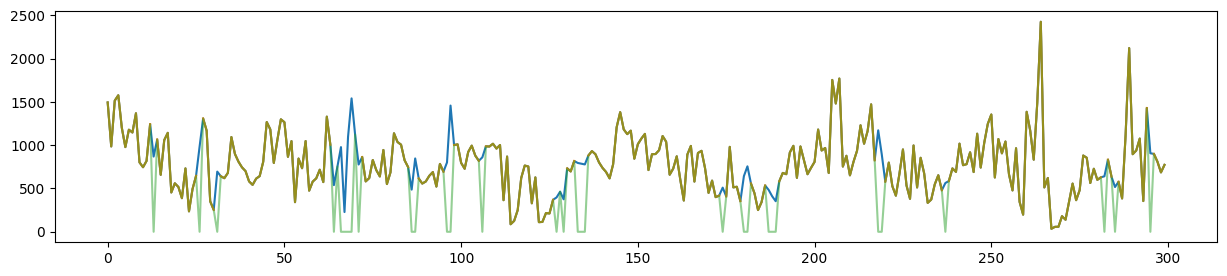

In [77]:
fig, ax = fig_ax()
ax.plot(data_train["holed_1"][100:400].values, alpha=1)
ax.plot(TS_missing["holed_1"][100:400].values)
ax.plot(res[100:400], alpha=0.5)
plt.show()